# Walmart

## Imports & loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE


In [23]:
# Import dataset
print("Loading dataset...")
dataset = pd.read_csv("Walmart.csv")
print("...Done.")
print()


Loading dataset...
...Done.



## EDA & cleaning

In [24]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Number of rows : 6435

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
unique,NaN,143,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,05-02-2010,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,45,NaN,NaN,NaN,NaN,NaN,NaN
mean,23.000000,NaN,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,NaN,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,NaN,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,NaN,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,NaN,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000



Percentage of missing values: 


Store           0.0
Date            0.0
Weekly_Sales    0.0
Holiday_Flag    0.0
Temperature     0.0
Fuel_Price      0.0
CPI             0.0
Unemployment    0.0
dtype: float64

In [25]:
# Create columns for year, month, day and day of week
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d-%m-%Y')
#dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek # 0: monday / 6: Sunday
#DayOfWeek is useless here : all values are friday
dataset['Week_Number']=dataset['Date'].dt.isocalendar().week
dataset['Day_of_Year_Number']=dataset['Date'].dt.dayofyear
dataset['Day'] = dataset['Date'].dt.day
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year

<AxesSubplot:>

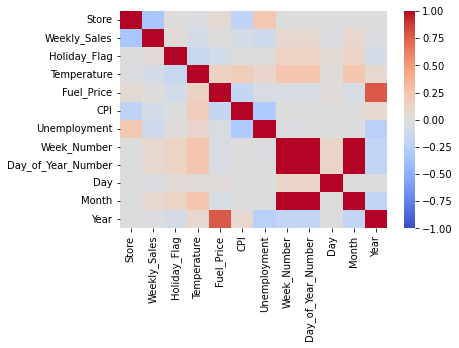

In [26]:
# Plot the heatmap and annotation on it
dataset_correlation = dataset.corr()
sns.heatmap(dataset_correlation, xticklabels=dataset_correlation.columns, yticklabels=dataset_correlation.columns, cmap='coolwarm', vmin=-1, vmax = 1)

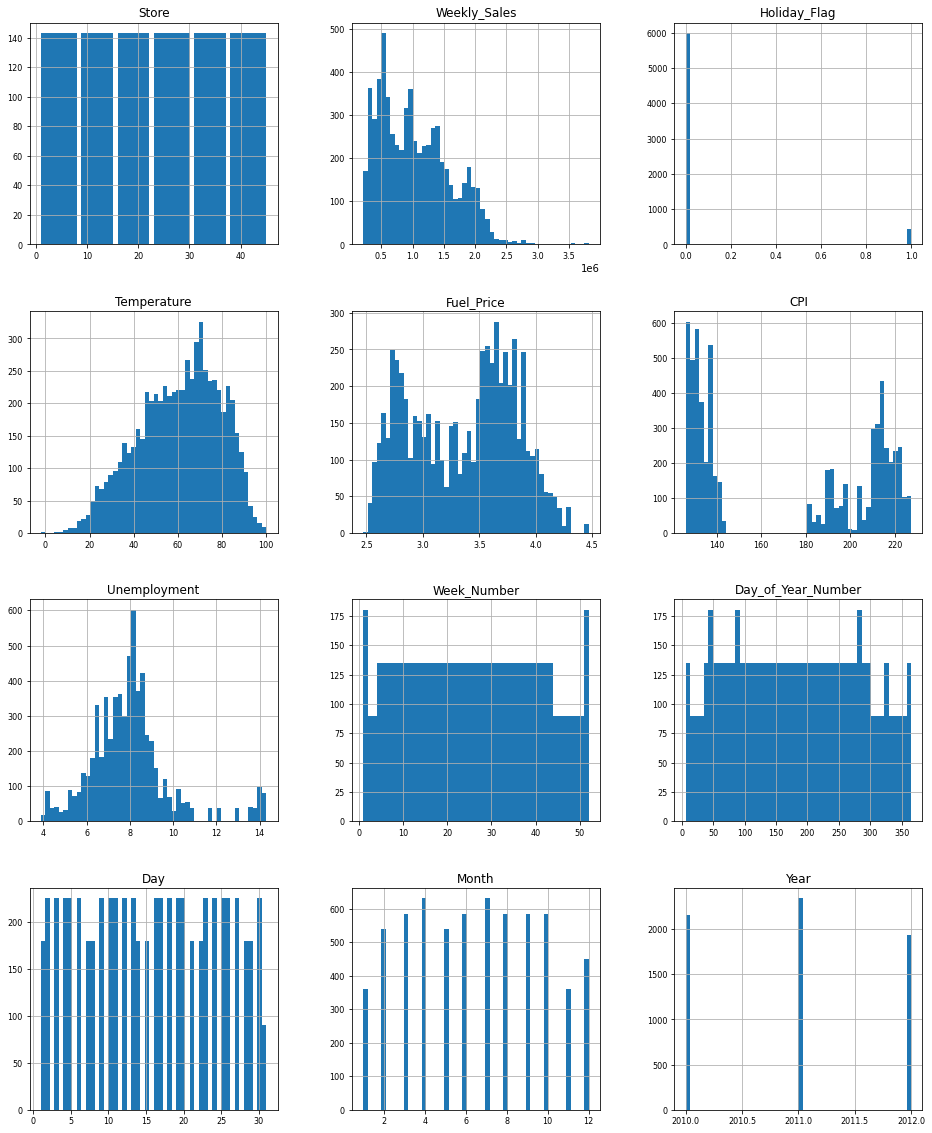

In [27]:
# listing dataframes types
list(set(dataset.dtypes.tolist()))
# include only float and integer
df_num = dataset.select_dtypes(include = ['float64', 'int64', 'UInt32'])
# display what has been selected
df_num.head()
# plot
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

**Note : The distribution shows that CPI and Fuel Price are not even remotely normal distributions, hence should NOT be trimmed using standard deviation**

In [28]:
#sns.pairplot(dataset)

In [29]:
# Drop lines containing invalid values or outliers
print("Number of rows before removing NAs : {}".format(dataset.shape[0]))
print()
dataset.dropna(inplace=True)
print("Number of rows after removing NAs : {}".format(dataset.shape[0]))
print()

print("Number of rows before removing outliers : {}".format(dataset.shape[0]))
print()

columns_to_clean = ['Temperature', 'Unemployment']
for column_to_clean in columns_to_clean:
    upper_limit = dataset[column_to_clean].mean() + 3 * dataset[column_to_clean].std()
    lower_limit = dataset[column_to_clean].mean() - 3 * dataset[column_to_clean].std()
    dataset = dataset[(dataset[column_to_clean] > lower_limit) & (dataset[column_to_clean] < upper_limit)]
    
print("Number of rows AFTER removing outliers : {}".format(dataset.shape[0]))
print()

Number of rows before removing NAs : 6435

Number of rows after removing NAs : 6435

Number of rows before removing outliers : 6435

Number of rows AFTER removing outliers : 6215



## Preprocessing

In [30]:
print(dataset.dtypes)

Store                          int64
Date                  datetime64[ns]
Weekly_Sales                 float64
Holiday_Flag                   int64
Temperature                  float64
Fuel_Price                   float64
CPI                          float64
Unemployment                 float64
Week_Number                   UInt32
Day_of_Year_Number             int64
Day                            int64
Month                          int64
Year                           int64
dtype: object


**Analysis :**

- *Store                          int64* : Categorical value : sales may depend on localization but in absence of equivalence table, to be kept as classification

- *Date                  datetime64[ns]* : Timestamp to drop, splitted in other columns therefore useless

- *Weekly_Sales                 float64* : Column to predict

- *Holiday_Flag                   int64* : Categorical To keep : high importance of Christmas

- *Temperature                  float64* : Numeric to To keep

- *Fuel_Price                   float64* : Numeric To keep Loosely correlated to sales : why ?

- *CPI                          float64* : Numeric To keep

- *Unemployment                 float64* : Numeric To keep

- *Week_Number                   UInt32* : Categorical to keep

- *Day_of_Year_Number             int64* : Categorical to drop, seems useless

- *Day                            int64* : Numerical to drop, could be interesting to check only where holiday = false (initial scatter shows that a bit more cleaning would be required such as dropping the whole holiday period

- *Month                          int64* : Categorical, to keep

- *Year                           int64*: Categorical, to keep

In [31]:
# Drop some columns
useless_cols = ['Date', 'Day', 'Day_of_Year_Number']
# Date : is a timestamp, useless as is and correlated
# Day : could be related to sales if people spend more

print("Dropping useless columns...")
dataset = dataset.drop(useless_cols, axis=1) # axis = 1 indicates that we are dropping along the column axis

print("...Done.")
print(dataset.head())

Dropping useless columns...
...Done.
   Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0      1    1643690.90             0        42.31       2.572  211.096358   
1      1    1641957.44             1        38.51       2.548  211.242170   
2      1    1611968.17             0        39.93       2.514  211.289143   
3      1    1409727.59             0        46.63       2.561  211.319643   
4      1    1554806.68             0        46.50       2.625  211.350143   

   Unemployment  Week_Number  Month  Year  
0         8.106            5      2  2010  
1         8.106            6      2  2010  
2         8.106            7      2  2010  
3         8.106            8      2  2010  
4         8.106            9      3  2010  


In [32]:
# Separate target variable Y from features X
target_name = 'Weekly_Sales'

print("Separating labels from features...")
Y = dataset.loc[:,target_name]
X = dataset.loc[:,[c for c in dataset.columns if c!=target_name]] # All columns are kept, except the target
print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0    1643690.90
1    1641957.44
2    1611968.17
3    1409727.59
4    1554806.68
Name: Weekly_Sales, dtype: float64

   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0      1             0        42.31       2.572  211.096358         8.106   
1      1             1        38.51       2.548  211.242170         8.106   
2      1             0        39.93       2.514  211.289143         8.106   
3      1             0        46.63       2.561  211.319643         8.106   
4      1             0        46.50       2.625  211.350143         8.106   

   Week_Number  Month  Year  
0            5      2  2010  
1            6      2  2010  
2            7      2  2010  
3            8      2  2010  
4            9      3  2010  



In [33]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X = X.values
Y = Y.tolist()
print("...Done")
print(X[0:5,:])
print()
print(Y[0:5])

Convert pandas DataFrames to numpy arrays...
...Done
[[1 0 42.31 2.572 211.0963582 8.106 5 2 2010]
 [1 1 38.51 2.548 211.2421698 8.106 6 2 2010]
 [1 0 39.93 2.514 211.2891429 8.106 7 2 2010]
 [1 0 46.63 2.561 211.3196429 8.106 8 2 2010]
 [1 0 46.5 2.625 211.3501429 8.106 9 3 2010]]

[1643690.9, 1641957.44, 1611968.17, 1409727.59, 1554806.68]


In [34]:
# First : always divide dataset into train set & test set !!
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=0)
# test_size indicates the proportion of rows from X and Y that will go into the test dataset while 
# maintaining the correspondance between the rows from X and Y 

# random_state is an argument that can be found in all functions that have a pseudo-random behaviour
# if random_state is not stated the function will derive a different random result everytime the cell 
# runs, if random_state is given a value the results will be the same everytime the cell runs while
# each different value of radom_state will derive a specific result
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [35]:
print(dataset.dtypes)

Store             int64
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Week_Number      UInt32
Month             int64
Year              int64
dtype: object


**Analysis :**

- [0] *Store                          int64* : Categorical value : sales may depend on localization but in absence of equivalence table, to be kept as classification

- [1] *Holiday_Flag                   int64* : Binary To keep : high importance of Christmas

- [2] *Temperature                  float64* : Numeric to To keep

- [3] *Fuel_Price                   float64* : Numeric To keep Loosely correlated to sales : why ?

- [4] *CPI                          float64* : Numeric To keep

- [5] *Unemployment                 float64* : Numeric To keep

- [6] *Week_Number                   UInt32* : Categorical to keep

- [7] *Month                          int64* : Categorical, to keep

- [8] *Year                           int64*: Categorical, to keep

In [36]:
# Create pipeline for numeric features
numeric_features = [1,2,3,4,5] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

In [37]:
# Create pipeline for categorical features
categorical_features = [0,6,7,8] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])


In [38]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [39]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

Performing preprocessings on train set...
[[31 0 63.39 3.734 220.8498468 7.057 11 3 2012]
 [15 0 74.67 4.004 135.9639355 7.806 30 7 2011]
 [15 1 62.36 2.837 132.7564516 8.099 36 9 2010]
 [42 0 74.04 4.202 129.089 8.494 19 5 2011]
 [30 0 83.59 2.64 211.0264684 8.099 30 7 2010]]
...Done.
  (0, 0)	-0.2657988944085566
  (0, 1)	0.16488703656133674
  (0, 2)	0.8266765785715288
  (0, 3)	1.233418304181081
  (0, 4)	-0.4935081906590453
  (0, 34)	1.0
  (0, 58)	1.0
  (0, 101)	1.0
  (0, 112)	1.0
  (1, 0)	-0.2657988944085566
  (1, 1)	0.7758809457953689
  (1, 2)	1.416613945587028
  (1, 3)	-0.9374166411985209
  (1, 4)	-0.009249617072992053
  (1, 18)	1.0
  (1, 77)	1.0
  (1, 105)	1.0
  (1, 111)	1.0
  (2, 0)	3.7622428875227403
  (2, 1)	0.10909592605503765
  (2, 2)	-1.1332264518466317
  (2, 3)	-1.019443423148878
  (2, 4)	0.18018664736053763
  (2, 18)	1.0
  (2, 83)	1.0
  (2, 107)	1.0
  (3, 0)	-0.2657988944085566
  (3, 1)	0.741756285971128
  (3, 2)	1.8492346813983953
  (3, 3)	-1.1132332166710488
  (3, 4)	0.4

## Training

In [40]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")


Train model...
...Done.


In [41]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()


Predictions on training set...
...Done.
[1386266.42527771  581711.91927573  647121.73960421 ... 1942493.73559032
 1384080.50398576 2040598.08149792]



## Model evaluation

In [42]:
X_train.shape

(1864, 113)

In [43]:
# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on test set...
[[17 0 62.64 2.82 126.1266 6.635 25 6 2010]
 [37 0 85.54 2.664 210.3617581 8.36 33 8 2010]
 [20 0 66.41 3.842 208.1265604 7.287 24 6 2011]
 [41 0 59.39 3.659 198.1267184 6.432 37 9 2012]
 [16 0 55.78 3.735 192.8470612 6.339 23 6 2011]]
...Done.
  (0, 0)	-0.2657988944085566
  (0, 1)	0.12426244153247823
  (0, 2)	-1.1703706564364973
  (0, 3)	-1.1889923308008932
  (0, 4)	-0.7663481346554603
  (0, 20)	1.0
  (0, 72)	1.0
  (0, 104)	1.0
  (1, 0)	-0.2657988944085566
  (1, 1)	1.364666743080292
  (1, 2)	-1.5112233573787854
  (1, 3)	0.9652005385764264
  (1, 4)	0.348933626941258
  (1, 40)	1.0
  (1, 80)	1.0
  (1, 106)	1.0
  (2, 0)	-0.2657988944085566
  (2, 1)	0.3284687392108735
  (2, 2)	1.062651525377729
  (2, 3)	0.9080385760942948
  (2, 4)	-0.3448039557794831
  (2, 23)	1.0
  (2, 71)	1.0
  (2, 104)	1.0
  (2, 111)	1.0
  (3, 0)	-0.2657988944085566
  (3, 1)	-0.05177747025924201
  (3, 2)	0.6628050877338896
  (3, 3)	0.6523070167645589
  (3, 4)	-0.897595785440465
 

In [44]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()


Predictions on test set...
...Done.
[ 898917.42594936  515448.48008013 2097918.61160961 ...  955328.86678137
  344063.7201112   210881.63839261]



In [45]:
# Print Adjusted R^2 scores
# n = number of observation, p = number of features

ntrain = len(Y_train)
ntest = len(Y_test)
p = X_test.shape[1]

r2train = r2_score(Y_train, Y_train_pred)
Adj_r2train = 1-(1-r2train)*(ntrain-1)/(ntrain-p-1)

r2test = r2_score(Y_test, Y_test_pred)
Adj_r2test = 1-(1-r2test)*(ntest-1)/(ntest-p-1)

print("Adjusted R2 score on training set : "+str(Adj_r2train))
print("Adjusted R2 score on test set : "+str(Adj_r2test))





Adjusted R2 score on training set : 0.9674948354901531
Adjusted R2 score on test set : 0.9557288388243218


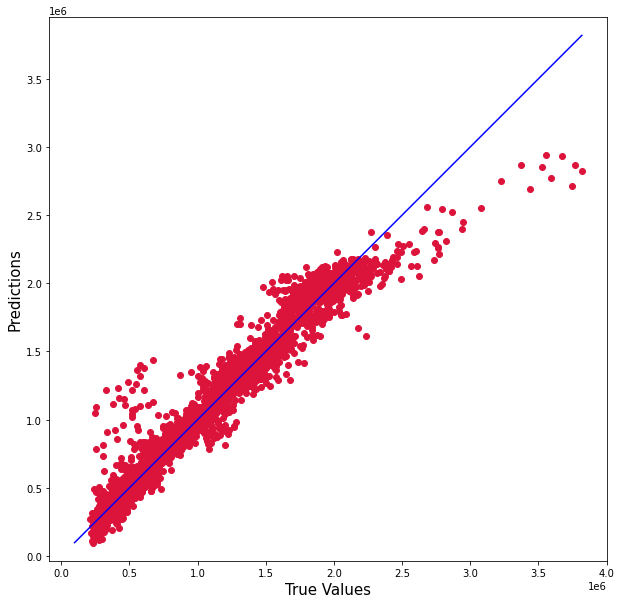

In [46]:
# Visualize the model
plt.figure(figsize=(10,10))
plt.scatter(Y_test, Y_test_pred, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(Y_test_pred), max(Y_test))
p2 = min(min(Y_test_pred), min(Y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()
